### Импорт библиотек

In [1]:
# %pip install numpy
# %pip install matplotlib
# %pip install pandas
# %pip install statsmodels

In [2]:
import os

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from IPython.display import clear_output
from pylab import rcParams
rcParams['figure.figsize'] = (20, 10)

In [3]:
def plot_assignation(data: pd.DataFrame, title: str, xlabel: str,
                     ylabel: str, figsize: tuple[int, int] = (20, 5)) -> None:
    _, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(data)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

### Наш датасет

In [4]:
df = pd.read_csv(
    os.path.join(
        os.sep,
        os.path.abspath(os.curdir),
        'data',
        'Daily foreign exchange rates AustraliaUS BritishUS CanadianUS DutchUS .csv'),
    index_col=0)

In [5]:
df.describe()

,X0.90440445,X0.450755015,X1.1684,X1.902,X4.0175,X1.726,X240.3,X1.595
count,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000
mean,1.275173,0.614102,1.284736,2.181853,6.119109,1.946779,161.154641,1.650417
std,0.200953,0.084824,0.096599,0.508379,1.232461,0.453921,53.624351,0.370644
min,0.841043,0.408831,1.120300,1.519200,4.009000,1.356500,81.120000,1.117200
25%,1.168224,0.567537,1.195800,1.841100,5.340000,1.637000,121.600000,1.406000
50%,1.307360,0.616713,1.278500,1.997500,5.827500,1.781500,138.500000,1.514000
75%,1.404494,0.659196,1.368300,2.509000,6.489500,2.258000,221.000000,1.896000
max,1.801802,0.950570,1.577000,3.914500,10.560000,3.452500,277.650000,2.924500


In [6]:
target_data = df['X0.90440445'].interpolate('linear').bfill()

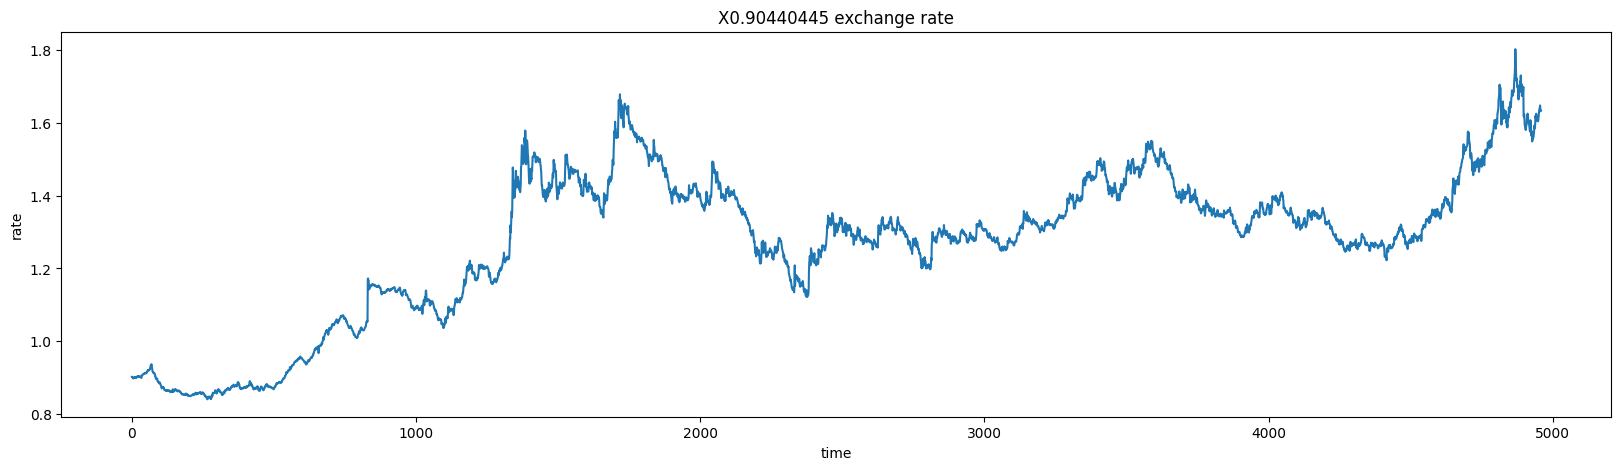

In [15]:
plot_assignation(target_data, 'X0.90440445 exchange rate', 'time', 'rate')

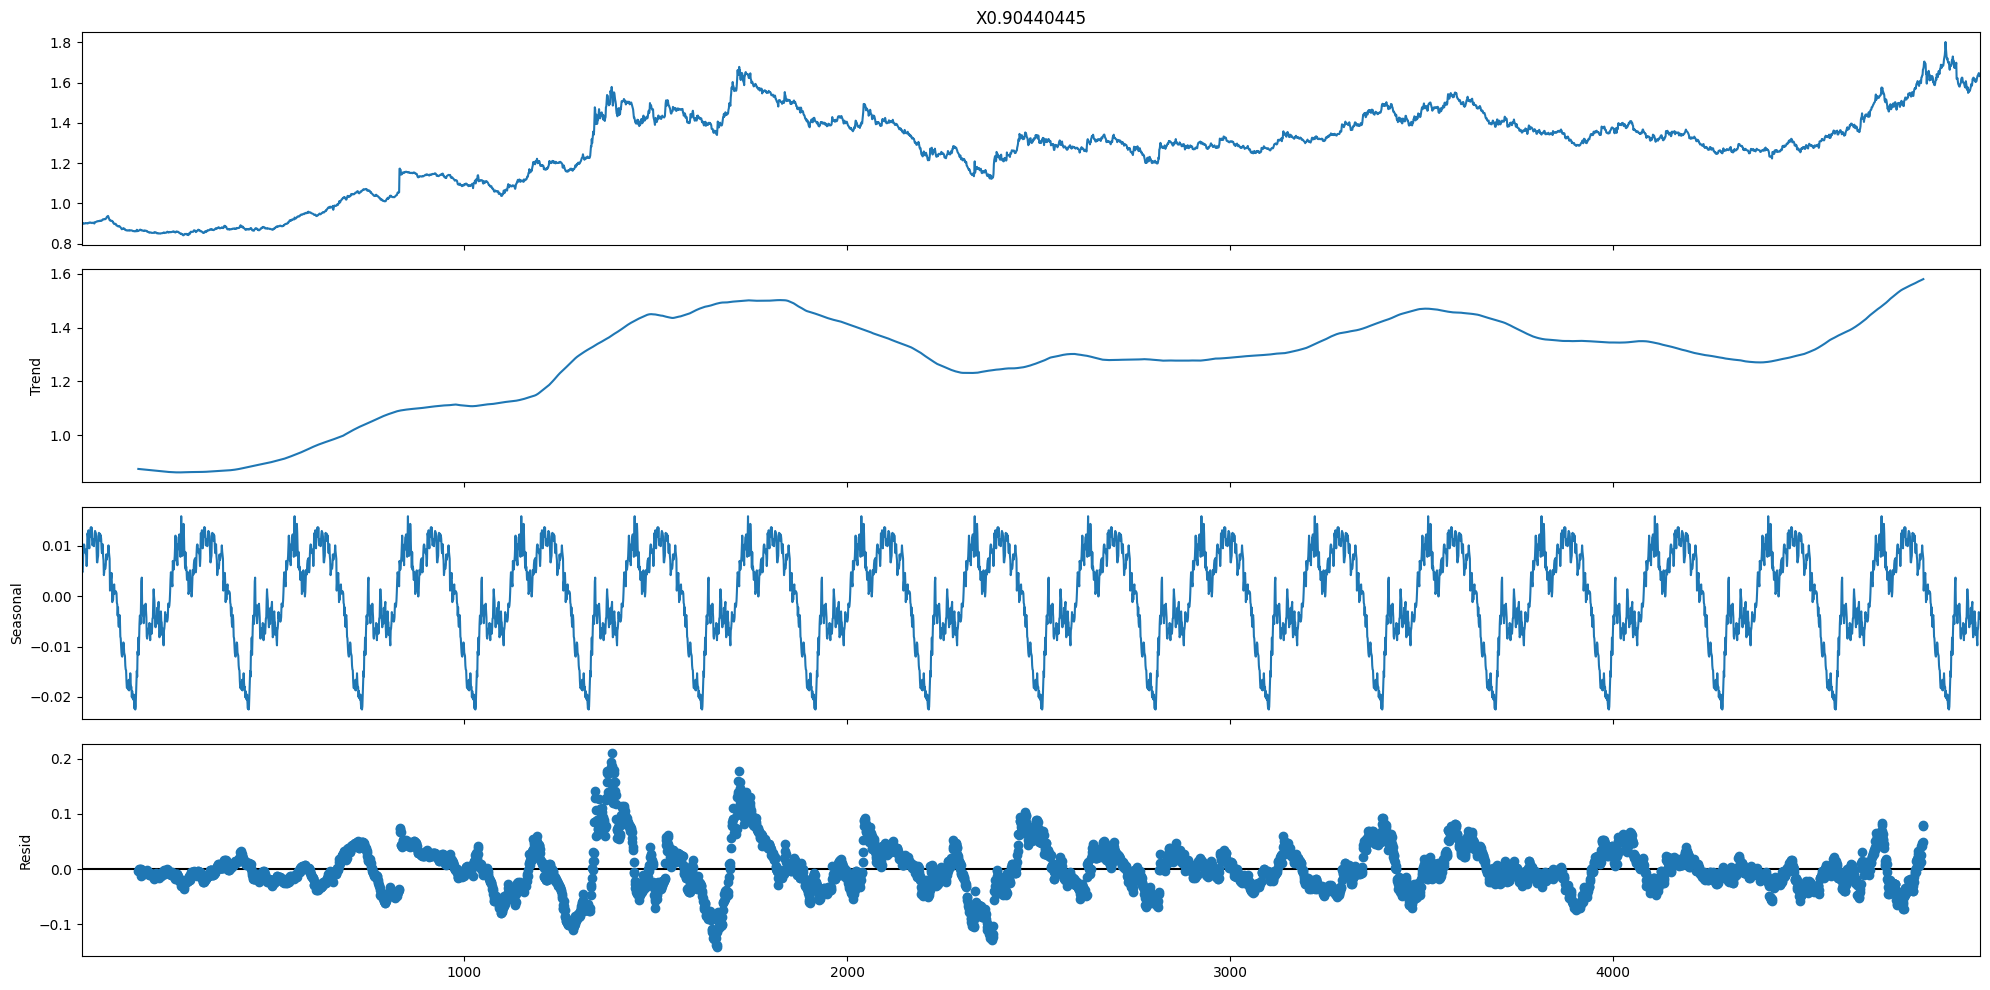

In [8]:
decompose = seasonal_decompose((target_data), period=296)
plot = decompose.plot()

In [9]:
# Есть предположение, что у ряда нет сезонности

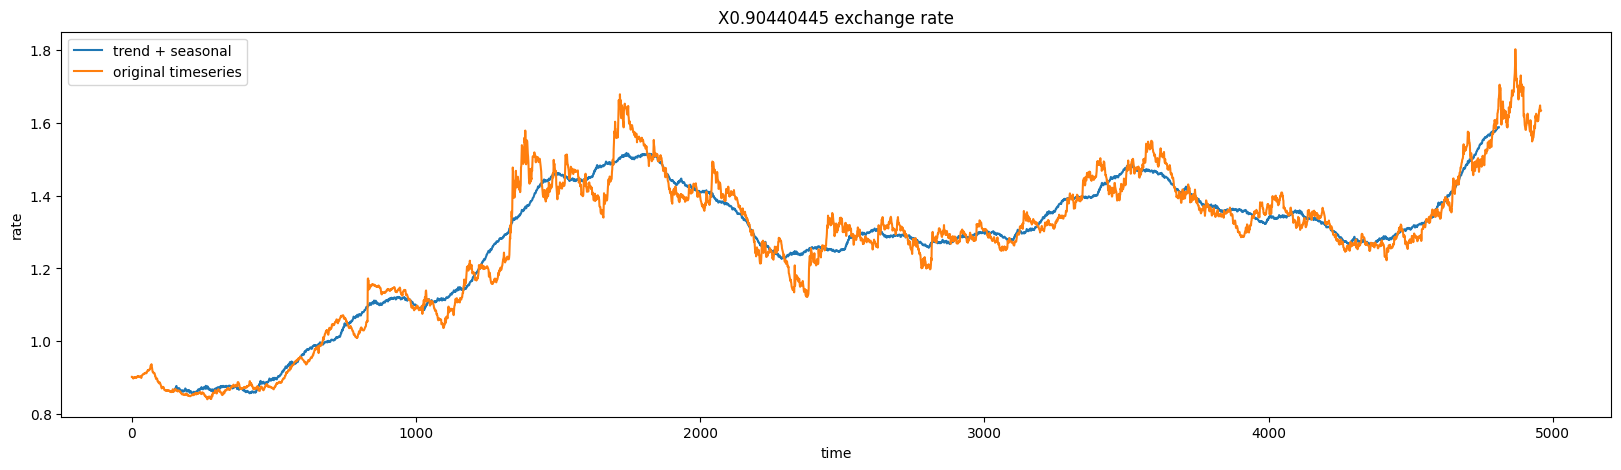

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))

plt.plot(decompose.trend + decompose.seasonal)
plt.plot(target_data)
plt.legend(['trend + seasonal', 'original timeseries'])

plt.title('X0.90440445 exchange rate')
plt.xlabel('time')
plt.ylabel('rate')
plt.show()

### Проверка на стационарность

In [11]:
def dickey_fuller_test(df: pd.DataFrame, name: str, alpha: float = 0.05) -> None:
    alpha = 0.05
    print(f'Тест Дики-Фуллера ряда {name}:')
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput, end='\n\n')

    if dfoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha * 100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")


dickey_fuller_test(target_data, "X0.90440445 exchange rate")

Тест Дики-Фуллера ряда X0.90440445 exchange rate:
Test Statistic                   -1.589791
p-value                           0.488720
#Lags Used                       21.000000
Number of Observations Used    4936.000000
Critical Value (1%)              -3.431676
Critical Value (5%)              -2.862126
Critical Value (10%)             -2.567082
dtype: float64

Значение p больше 5.0%. Ряд не стационарный.


### Тренд как скользящее среднее и полосы Боллинджера

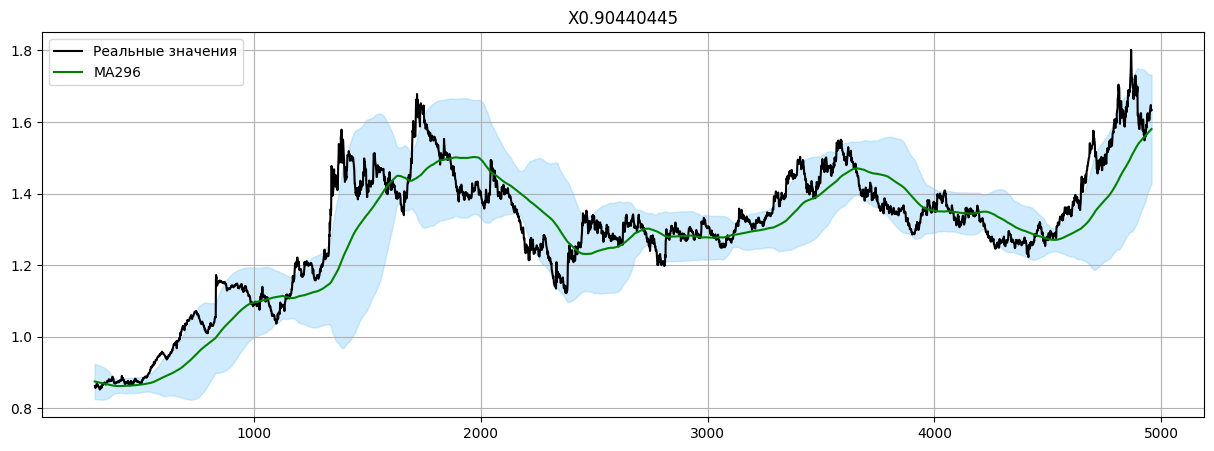

In [12]:
# указываем размер окна
window = 296

# вычисляем скользящее среднее и стандартное отклонение
rolling_mean = target_data.rolling(window=window).mean()
rolling_std = target_data.rolling(window=window).std()

plt.figure(figsize=(15, 5))
plt.title(target_data.name)
plt.plot(target_data[window:], label='Реальные значения', color="black")

# отрисовываем скользящее среднее
plt.plot(rolling_mean, 'g', label='MA' + str(window))

# отрисовываем верхний и нижний интервалы
lower_bound = rolling_mean - (1.96 * rolling_std)
upper_bound = rolling_mean + (1.96 * rolling_std)

plt.fill_between(x=target_data.index, y1=lower_bound, y2=upper_bound,
                 color='lightskyblue', alpha=0.4)
plt.legend(loc='best')
# показываем сетку на графике
plt.grid(True)
plt.show()

### Аддитивный и мультипликативный ряды

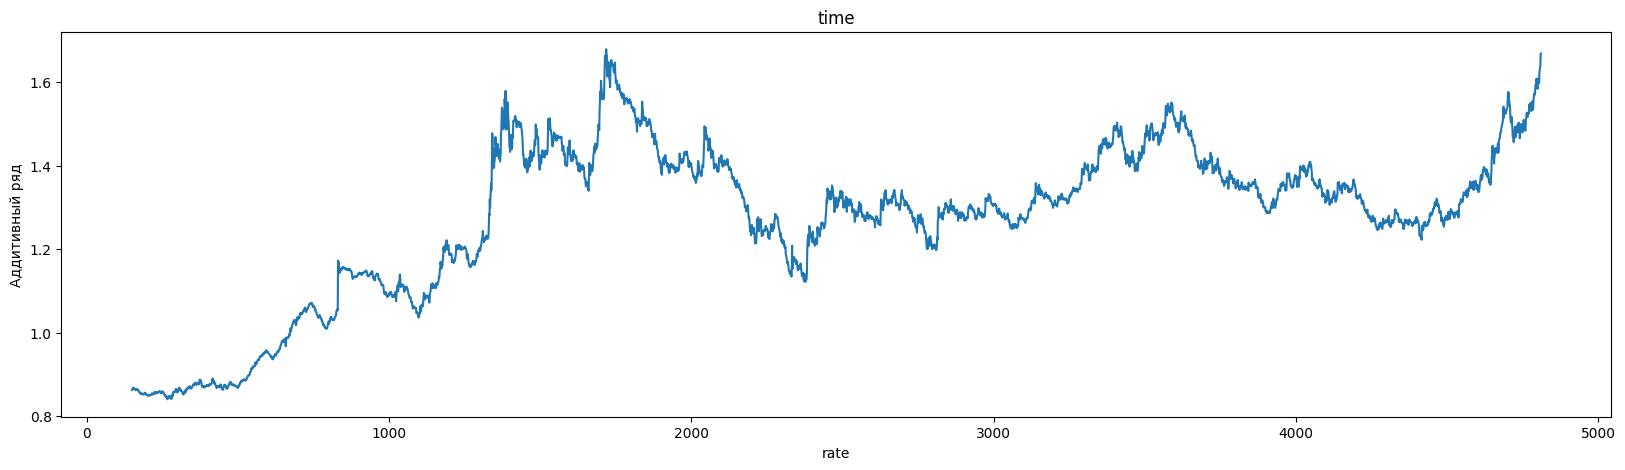

In [13]:
additive_series = decompose.trend + decompose.seasonal + decompose.resid

plot_assignation(additive_series, 'Аддитивный ряд', 'time', 'rate')

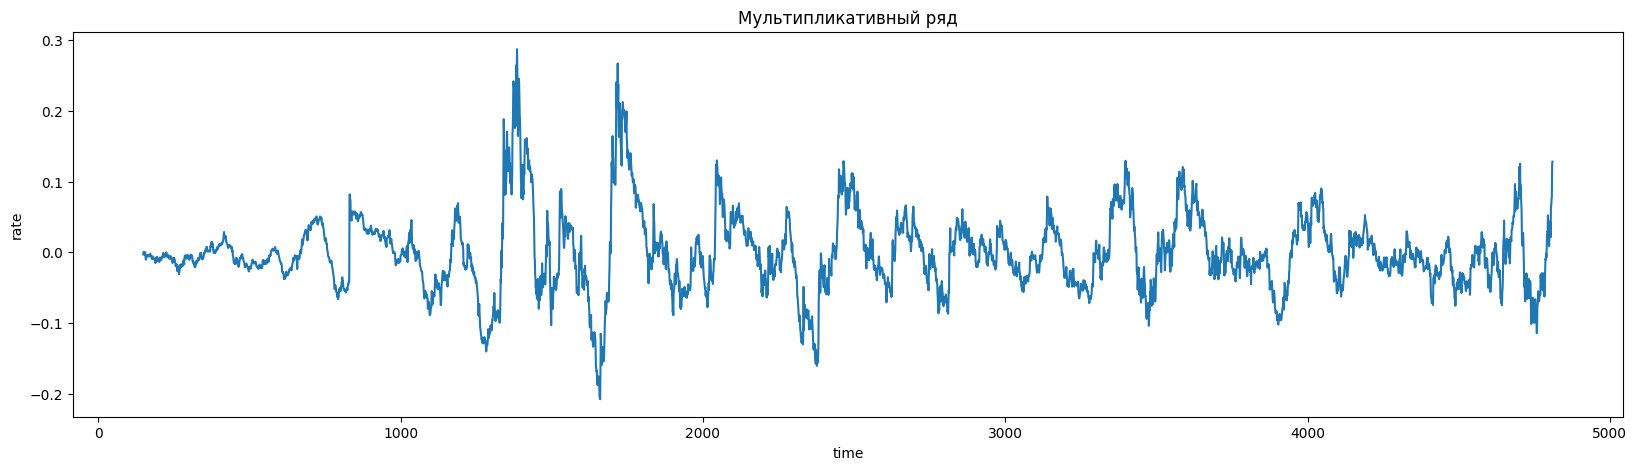

In [16]:
multiplicative_series = decompose.trend * \
    (decompose.seasonal + 1) * decompose.resid

plot_assignation(
    multiplicative_series,
    'Мультипликативный ряд',
    'time',
    'rate')
plt.show()

### Автокорреляция

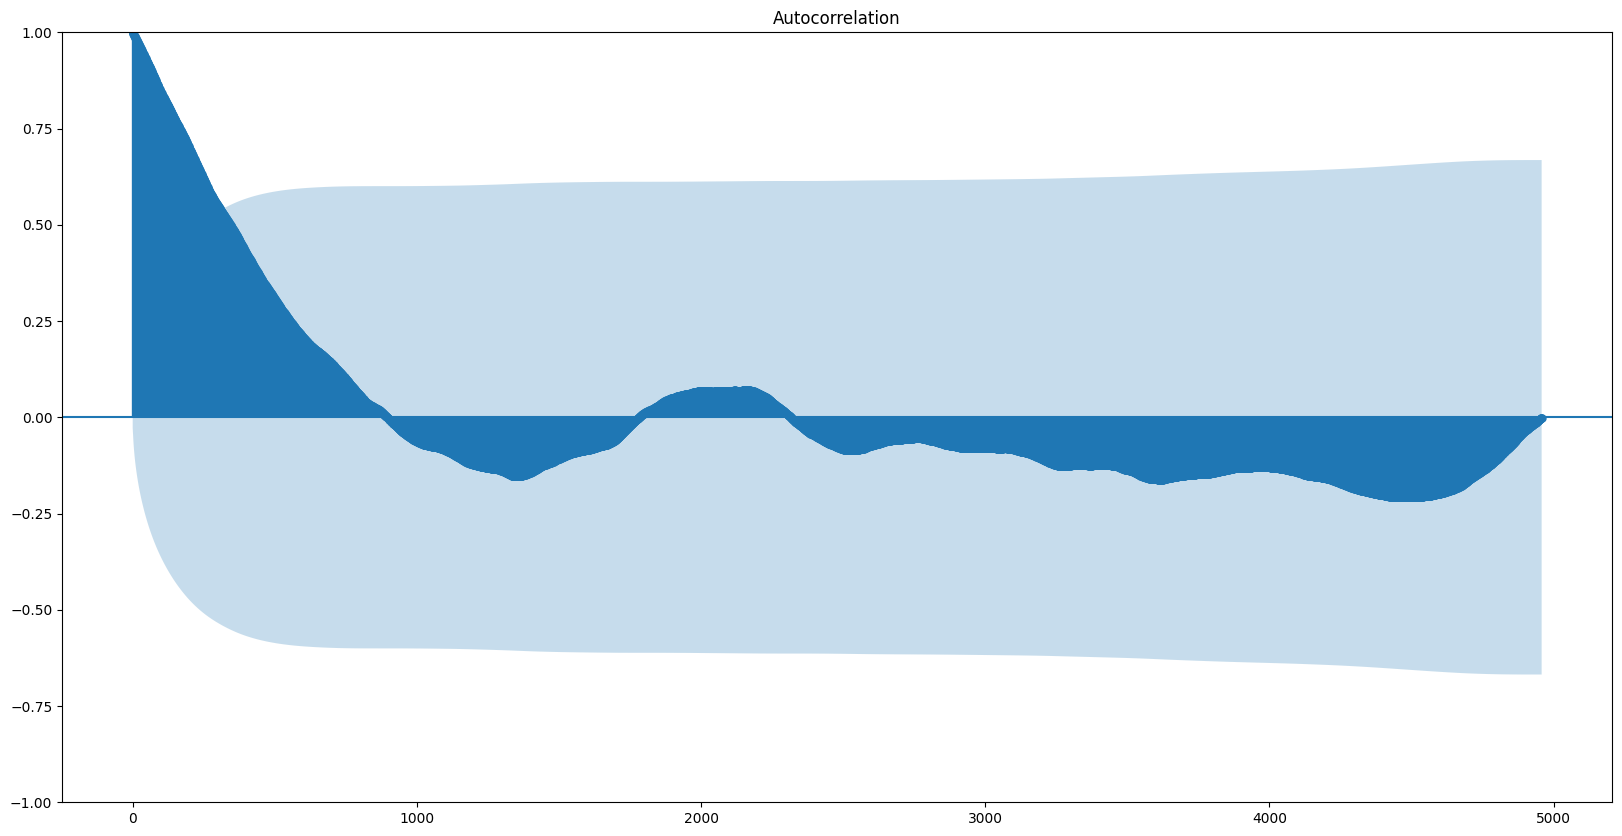

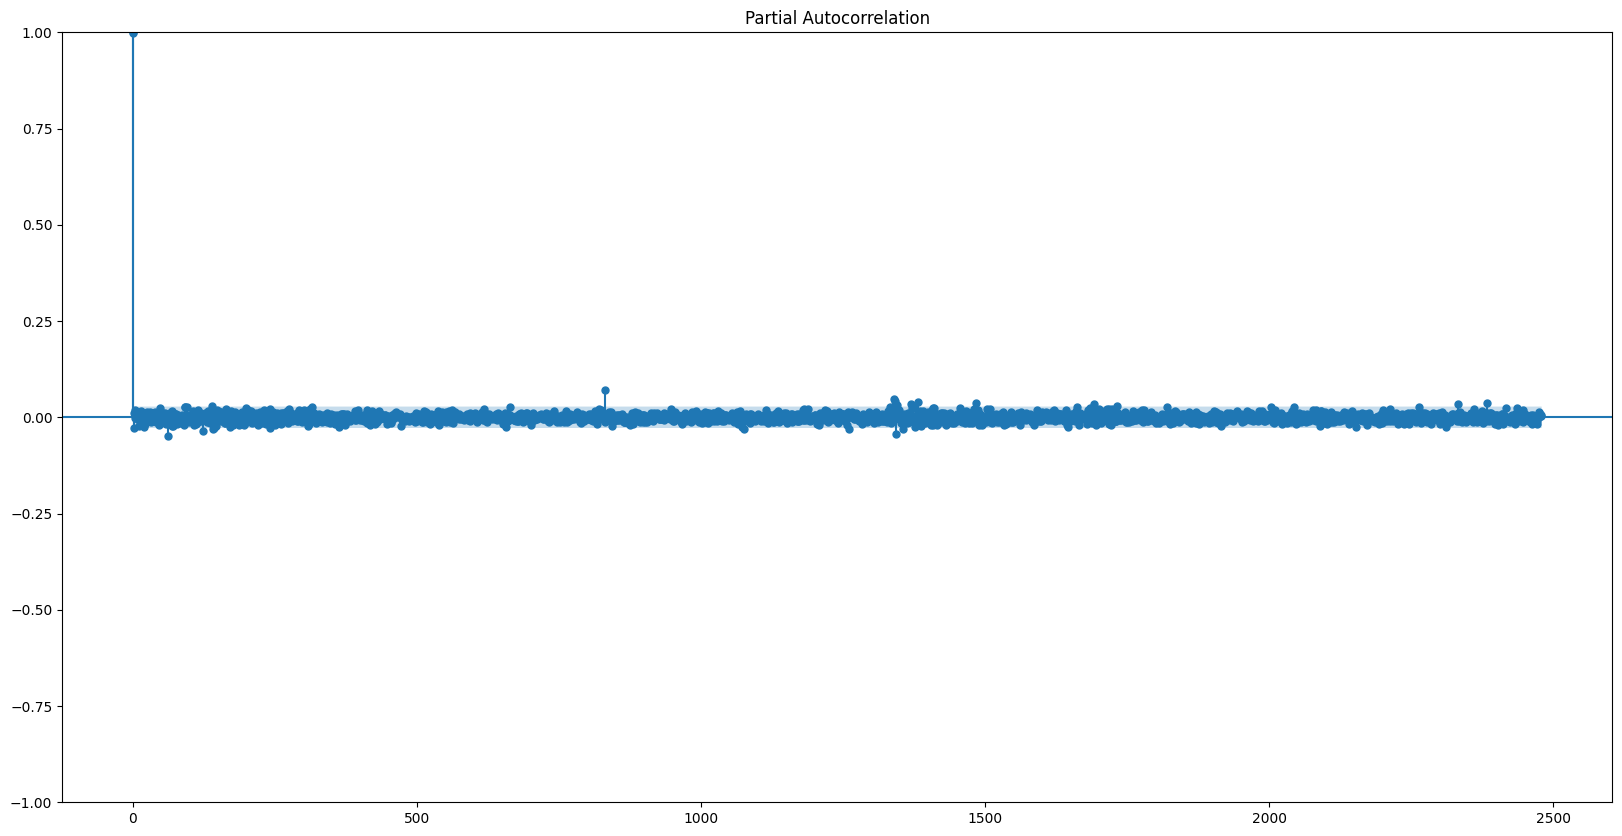

In [85]:
import statsmodels.tsa.api as smt

ts = target_data

sc_plot = smt.graphics.plot_acf(ts, lags=4957)
pac_plot = smt.graphics.plot_pacf(ts, lags=2479)

plt.show()